# Linear Regression Implementation from Scratch

We will implement the entire method from scratch,
including the model,
the loss function, the minibatch stochastic gradient descent optimizer, and the training function

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

Before we can begin optimizing our model's parameters
we need to have some parameters in the first place

In [2]:
class LinearRegressionScratch(d2l.Module):
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, size=(num_inputs, 1),
                              requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

Define our model,
relating its inputs and parameters to its outputs

In [3]:
@d2l.add_to_class(LinearRegressionScratch)
def forward(self, X):
    """The linear regression model."""
    return torch.matmul(X, self.w) + self.b

Updating our model requires taking
the gradient of our loss function,
define the loss function first

In [7]:
def mse(y_hat, y):  
    """Squared loss."""
    loss = (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
    return loss.mean()

@d2l.add_to_class(LinearRegressionScratch)
def training_step(self, batch):
    X, y = batch
    l = mse(self(X), y)
    epoch = self.trainer.train_batch_idx / self.trainer.num_train_batches
    self.board.xlabel = 'epoch'
    self.board.draw(epoch, l, 'loss', every_n=10)
    return l

class SGD(d2l.HyperParameters):
    def __init__(self, params, lr):
        """Minibatch stochastic gradient descent."""
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

@d2l.add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

Implement the main training loop

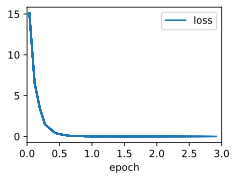

In [10]:
@d2l.add_to_class(d2l.Trainer)  
def fit(self, model, data):
    model.trainer = self
    self.prepare_data(data)
    self.reset_counters()
    model.board.xlim = [0, self.max_epochs]
    optim = model.configure_optimizers()
    for self.epoch in range(self.max_epochs):
        self.fit_epoch(model, optim)

@d2l.add_to_class(d2l.Trainer)  
def fit_epoch(self, model, optim):
    model.train()
    for batch in self.train_dataloader:
        loss = model.training_step(batch)
        optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            model.validation_step(batch)
        self.val_batch_idx += 1

model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

Evaluate our success in training
by comparing the true parameters
with those that we learned

In [11]:
print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 4.6611e-05, -5.0020e-04], grad_fn=<SubBackward0>)
error in estimating b: tensor([-0.0015], grad_fn=<RsubBackward1>)
